# Detection et reconnaissance des couleurs des carrés
Dans ce notebook, nous présentons une technique de détectio des carrées dans une image ainsi que l'extraction de la séquence de couleurs.

In [63]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

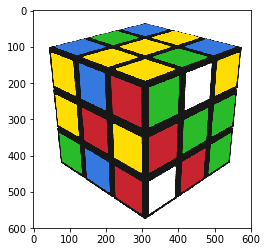

In [64]:
img_rw = cv2.imread("C:/Users/aloui_000/Documents/grebot/ConstructionSequenceDetector/rc.png")
img = cv2.cvtColor(img_rw, cv2.COLOR_BGR2RGB)

plt.imshow(img)

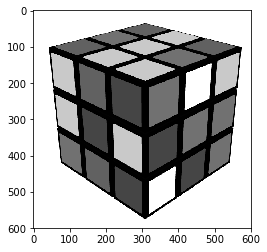

In [65]:
img_gray = cv2.cvtColor(img_rw, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap='gray')

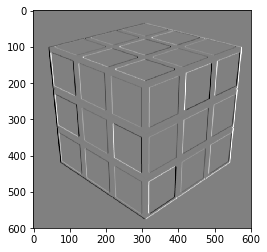

In [66]:
img_sobel = cv2.Sobel(img_gray,cv2.CV_64F,1,0,ksize=5)
plt.imshow(img_sobel, cmap='gray')

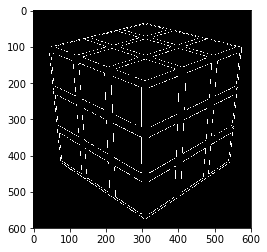

In [67]:
img_canny = cv2.Canny(img_gray, 100,200)
plt.imshow(img_canny, cmap='gray')

In [68]:
im2, contours, hierarchy = cv2.findContours(img_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

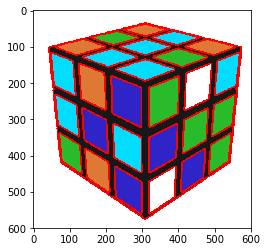

In [69]:
img_contoured=img_rw.copy()
cv2.drawContours(img_contoured, contours, -1, (255,0,0), 3)
plt.imshow(img_contoured)

rectangle found at [62 13] with colour [25 25 25]

rectangle found at [62 13] with colour [25 25 25]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [ 47  36 199]

rectangle found at [62 13] with colour [ 47  36 199]

rectangle found at [62 13] with colour [255 255 255]

rectangle found at [62 13] with colour [255 255 255]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [ 47  36 199]

rectangle found at [62 13] with colour [ 47  36 199]

rectangle found at [62 13] with colour [ 42 187  42]

rectangle found at [62 13] with colour [ 42 187  42]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [23 23 23]

rectangle found at [62 13] with colour [  0 221 255]

rect

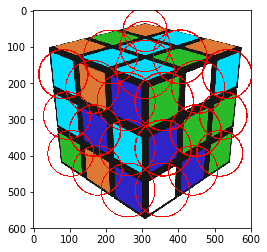

In [99]:
img_contoured_onlyrects=img_rw.copy()
nb_detectedRects=0
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)
    if(len(approx)==4):
        nb_detectedRects = nb_detectedRects + 1
        (x,y),radius = cv2.minEnclosingCircle(approx)
        center = (int(x),int(y))
        radius = int(radius)
        print("rectangle found at {} with colour {}\n".format(pos,img_rw[int(x), int(y)]))
        cv2.circle(img_contoured_onlyrects,center,radius,(255,0,0),2)
        #cv2.drawContours(img_contoured_onlyrects, approx, -1, (255,0,0), 3)
plt.imshow(img_contoured_onlyrects)
print("Detected {} rectangles".format(nb_detectedRects))